# Convolutional and recurrent neural networks

In the last lecture we introduced deep learning, talked about the need to go deep, and trained a deep neural network using `sklearn` and then using `tensorflow`. The networks that we trained then were examples of **dense** or **fully connected** networks, meaning that every feature in the previous layer is connected to every feature in the current layer. Because of this property, dense neworks are very likely to overfit and have a lot of parameters. Too many parameters means that we run into computational limits as we try to go deeper. 

In this lecture, we want to expand on the idea of deep learning by proposing some modifications to dense networks. The first modification will introduce the idea of **convolutional neuron networks** which learn features in such a way that we take **locality** into account. The next modification will introduce **recurrent neural networks** which learn features when we have sequential data (i.e. data where order matters). Both ideas rely on **shared parameters** to greatly reduce the number of parameters in a neural networks, allowing us to **go deeper**.

## MNIST and convolutional networks

Let's begin by loading the MNIST data again.

In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [3]:
# from tensorflow.keras.utils import to_categorical
# y_train_onehot = to_categorical(y_train, num_classes = 10)
# y_test_onehot = keras.utils.to_categorical(y_test, num_classes = 10)

The following helper function will later be used to plot the training and validation data accuracy and loss for the models we train.

In [4]:
import os
import matplotlib.pyplot as plt

def plot_train_test_performance(model):

    fig = plt.figure(figsize = [10, 10])
    plt.subplot(2,1,1)
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'lower right')

    plt.subplot(2,1,2)
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper right')
    plt.tight_layout()
    


The 2D convolutional neural networks we work with here expect the input data to be images. However, images are usually not 2D objects but 3D objects: the first two dimensions encode the size of the image, and the third dimension is for the **channel**. For example, a colored image oncoded as **RGB** (red, green, blue) has three channels. A greyscale image like the ones in the MNIST dataset have only one channel, but we still need the data to be 3D. Of course, the dataset itself then needs another dimension for the training example. This means our data has the following dimensionality:

$$\text{training examples} \times \text{row pixels} \times \text{column pixels} \times \text{channel}$$

We need to make sure that our data abides by the dimensionality above, and we use `reshape` for that. We also normalize the data as we did in the previous lecture by dividing the pixel values by 255 so the pixel values are between 0 and 1.

In [5]:
print('x_train shape (before):', X_train.shape)
print('x_test shape (before):', X_test.shape)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print('x_train shape (after):', X_train.shape)
print('x_test shape (after):', X_test.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

x_train shape (before): (60000, 28, 28)
x_test shape (before): (10000, 28, 28)
x_train shape (after): (60000, 28, 28, 1)
x_test shape (after): (10000, 28, 28, 1)


As usual, before training a new model, let's first train a baseline model so we can compare performances. As our baseline, we choose a neural network with only a single hidden layer with 128 neurons in it.

In [6]:
model_baseline = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
    tf.keras.layers.Dense(128,activation = 'relu'),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

We now compile our model. To speed up the training, we use the Adam optimizer, which is more efficient than vanilla SGD.

In [7]:
model_baseline.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(0.01),
    metrics = ['accuracy'],
)

We now train our model, specifying a mini-batch size of 128 and a total of 20 epochs.

In [8]:
model_baseline.fit(
    X_train, 
    y_train, 
    batch_size = 128,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test, y_test)
)

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2349 - accuracy: 0.9282 - val_loss: 0.1409 - val_accuracy: 0.9574
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1209 - accuracy: 0.9640 - val_loss: 0.1106 - val_accuracy: 0.9681
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0982 - accuracy: 0.9708 - val_loss: 0.1053 - val_accuracy: 0.9702
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0861 - accuracy: 0.9745 - val_loss: 0.1272 - val_accuracy: 0.9633
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0787 - accuracy: 0.9760 - val_loss: 0.1265 - val_accuracy: 0.9666
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0723 - accuracy: 0.9788 - val_loss: 0.1510 - val_accuracy: 0.9606
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0705 - accuracy: 0.9788 - val_loss: 0.1380 - val_accuracy: 0.9642
Epoch 

And we now plot accuracy and loss for the training and validation data, epoch by epoch.

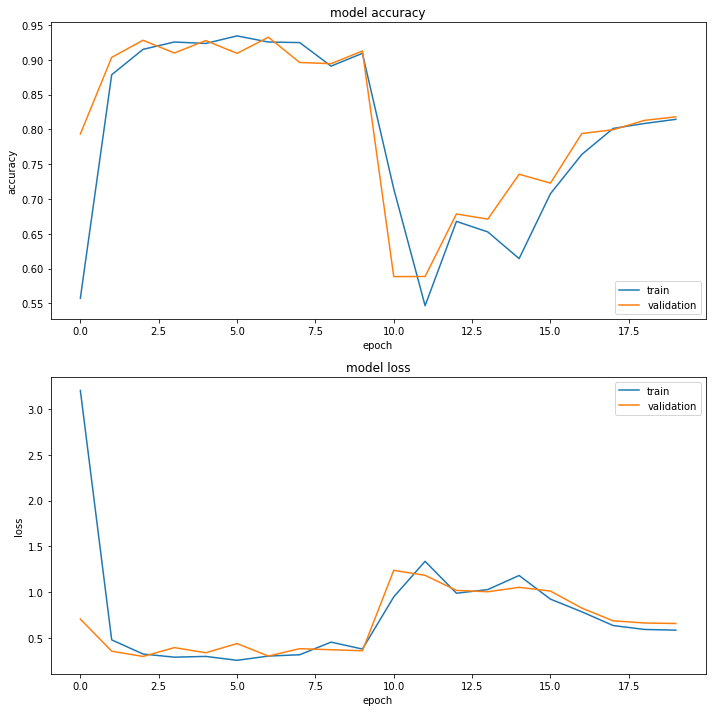

In [21]:
plot_train_test_performance(model_baseline)

Time to train a convolutional neural network. Foretunately, there's very little we need to change in the code: The only changes show up in the architecture of the model, where we now use `Conv2D` and `MaxPool2D` layers initially. Note that the flat layers don't disappear. Instead they get pushed to the end of the network.

In [31]:
model_cnn = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)),
  tf.keras.layers.MaxPool2D((2, 2)),
  # tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
  # tf.keras.layers.MaxPool2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation = 'relu'),
  tf.keras.layers.Dense(10, activation = 'softmax')
])

model_cnn.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(0.01),
    metrics = ['accuracy'],
)

model_cnn.fit(
    X_train, 
    y_train, 
    batch_size = 128,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test, y_test)
)

Epoch 1/20
469/469 [==============================] - 21s 45ms/step - loss: 0.1405 - accuracy: 0.9566 - val_loss: 0.0675 - val_accuracy: 0.9778
Epoch 2/20
469/469 [==============================] - 22s 47ms/step - loss: 0.0519 - accuracy: 0.9840 - val_loss: 0.0546 - val_accuracy: 0.9833
Epoch 3/20
469/469 [==============================] - 21s 45ms/step - loss: 0.0350 - accuracy: 0.9891 - val_loss: 0.0785 - val_accuracy: 0.9812
Epoch 4/20
469/469 [==============================] - 21s 45ms/step - loss: 0.0274 - accuracy: 0.9908 - val_loss: 0.0962 - val_accuracy: 0.9751
Epoch 5/20
469/469 [==============================] - 20s 43ms/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.0717 - val_accuracy: 0.9828
Epoch 6/20
469/469 [==============================] - 21s 44ms/step - loss: 0.0262 - accuracy: 0.9919 - val_loss: 0.0864 - val_accuracy: 0.9793
Epoch 7/20
469/469 [==============================] - 20s 43ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.0924 - val_accuracy:

In [ ]:
plot_train_test_performance(model_cnn)

### Exercise

- Train the model for another two epochs by copying and pasting the **training portion** of the code above in the cell below. What is the starting accuracy at epoch 1? What does this tell you about the model?

In [32]:
model_cnn.fit(
    X_train, 
    y_train, 
    batch_size = 128,
    epochs = 22,
    verbose = 1,
    validation_data = (X_test, y_test)
)

Epoch 1/22
469/469 [==============================] - 21s 46ms/step - loss: 0.0185 - accuracy: 0.9968 - val_loss: 0.1887 - val_accuracy: 0.9816
Epoch 2/22
469/469 [==============================] - 20s 44ms/step - loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.2151 - val_accuracy: 0.9817
Epoch 3/22
469/469 [==============================] - 21s 46ms/step - loss: 0.0090 - accuracy: 0.9981 - val_loss: 0.2541 - val_accuracy: 0.9811
Epoch 4/22
469/469 [==============================] - 22s 46ms/step - loss: 0.0189 - accuracy: 0.9970 - val_loss: 0.2067 - val_accuracy: 0.9818
Epoch 5/22
469/469 [==============================] - 20s 42ms/step - loss: 0.0195 - accuracy: 0.9965 - val_loss: 0.2779 - val_accuracy: 0.9809
Epoch 6/22
469/469 [==============================] - 20s 42ms/step - loss: 0.0193 - accuracy: 0.9969 - val_loss: 0.2196 - val_accuracy: 0.9835
Epoch 7/22
469/469 [==============================] - 21s 44ms/step - loss: 0.0087 - accuracy: 0.9985 - val_loss: 0.2328 - val_accuracy:

When you create a model with `keras`, assuming your model is called `model`, you can use `model.summary()` to print some useful information about the model. You can print the model summary prior to training, in order to have an idea of the complexity of the model.

- Print the model summary for both the dense neural network and the CNN we trained above. How many parameters do each have?

In [35]:
model_baseline.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                401472    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 402,442
Trainable params: 402,442
Non-trainable params: 0
_________________________________________________________________


### End of exercise

If we wanted to save the trained model we can use the `save_weights` method. This is useful in case we (1) need to later train the model further, (2) fine-tune the model to a more specific task (called transfer learning), or (3) load the model in a scoring environment to get predictions.

In [38]:
model_cnn.save_weights("model_digit.h5")
print("Saved model to disk")

Saved model to disk


# IMBD and recurrent networks

We now shift focus to recurrent neural networks. Recurrent networks become sort of demystified once we realize that they are just a regular neural network unrolled. Using `keras` we don't have to manually do the unrolling: the details are handled under the hood.

For the next example, we use the IMDB dataset which consists of 25000 **movie reviews** for training and 25000 for testing. The label is the user's **sentiment** about the movie: positive or negative. We use recurrent neural networks to train a binary classifier to do sentiment analysis.

In [39]:
imbd = tf.keras.datasets.imdb

After loading the data, we will split it into trining and testing. Note that we can decide the size of the corpus to use. This can be handy when we need to try our code and want to keep computations under control. By specifying for example to use a corpus with 10,000 words, we limit the reviews to use the most common 10,000 words. As we will later see, any word in the review that doesn't make the cut is replaced by a generic `<UNK>` marker.

In [40]:
num_of_words = 10000
(x_train, y_train), (x_test, y_test) = imbd.load_data(num_words = num_of_words)

17465344/17464789 [==============================] - 1s 0us/step


We now check the first row of the data to see what it looks like.

In [41]:
print(x_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


That doesn't look much like a movie review, does it? The reason is that the data that keras is presenting us with has already been **pre-processed**, meaning that instead of looking at the raw movie review, each review has been turned into a numeric representation. One kind of representation we are already familiar with is one-hot-encoding. We can apply one-hot-encoding to this data too, and it would look like this:

- get a list of all the unique words across **all** the reviews (we call this a **corpus**) and create dummy columns for each word
- for each review let the word dummy column be 1 if the word is present in the review and 0 otherwise

The problem with the above approach is that we end up with lots of dummy columns (one per word) and for any given review the majority of the encodings would be zero. One-hot encoding can still be a good idea, but we need to find a way to representing in a **sparse** format instead.

One approach is to sort the corpus by most frequent to least frequent. We then index the words using this order, starting with index 1, so that the index 1 would encodes most frequent word in the corpus, 2 would be the second most frequent word, etc. We can download the **word to index dictionary** used by the IMBD data set to see this.

In [42]:
word_to_index = tf.keras.datasets.imdb.get_word_index()
print("There are {:,} in the corpus and indexing starts at {}.".format(
    len(word_to_index.keys()), min(word_to_index.values())))

1646592/1641221 [==============================] - 0s 0us/step
There are 88,584 in the corpus and indexing starts at 1.


Let's print the word and index for the first 10 words. Note that `word_index` is a dictionary, so it is not necessarily sorted in the order of frequency.

In [43]:
first_10_keys = list(word_to_index.keys())[:10]

for k in first_10_keys:
    print(f"For word \"{k}\" \t the index is {word_to_index[k]}.")

For word "fawn" 	 the index is 34701.
For word "tsukino" 	 the index is 52006.
For word "nunnery" 	 the index is 52007.
For word "sonja" 	 the index is 16816.
For word "vani" 	 the index is 63951.
For word "woods" 	 the index is 1408.
For word "spiders" 	 the index is 16115.
For word "hanging" 	 the index is 2345.
For word "woody" 	 the index is 2289.
For word "trawling" 	 the index is 52008.


We now take this word to index and add a few more "words" to it. These are not really words, but markers that are used by the algorithm:

By convention index 0 though 3 are reserved for the some special markers shown below. What these markers are will become clear later. We make room for these markers in the word to index dictionary by pushing the current indexes out.

In [44]:
word_to_index = {k:(v + 3) for k, v in word_to_index.items()}
word_to_index["<PAD>"] = 0
word_to_index["<START>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

Let's now create a **reverse dictionary**, that is one where we switch keys and values.

In [45]:
index_to_word = {value: key for key, value in word_to_index.items()}

In [46]:
for i in range(10):
    print(f"For index {i} the word is \"{index_to_word[i]}\".")

For index 0 the word is "<PAD>".
For index 1 the word is "<START>".
For index 2 the word is "<UNK>".
For index 3 the word is "<UNUSED>".
For index 4 the word is "the".
For index 5 the word is "and".
For index 6 the word is "a".
For index 7 the word is "of".
For index 8 the word is "to".
For index 9 the word is "is".


### Exercise

Let's look at the first review in the data:

In [47]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


- Write a function named `decode_review` that takes as input a review like the above one and uses `index_to_word` to return the actual review as a string. 

In [53]:
def decode_review(indexes):
    return ' '.join([index_to_word[i] for i in indexes])


- We now decode the first review in the data using your function:

In [56]:
print(decode_review(x_train[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

- What do you think the presence of `<UNK>` in the review means?

### End of exercise

We saw how we need to force all images in a convolutional network to have a same size by choosing a size and then padding smaller images around the edges until they have the same size. We need to do the same with our reviews: we need to pick a maximum number of words a review can have, and (1) trim longer reviews and (2) pad shorter reviews. Foretunately, `keras` already has a function for doing that.

In [57]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_review_length = 300
x_train_padded = pad_sequences(x_train, maxlen = max_review_length)
x_test_padded = pad_sequences(x_test, maxlen = max_review_length)

Let's see what the first review looks like once it's padded.

In [58]:
x_train_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    1,   14,   22,   16,   43,  530,
        973, 1622, 1385,   65,  458, 4468,   66, 3941,    4,  173,   36,
        256,    5,   25,  100,   43,  838,  112,   50,  670,    2,    9,
         35,  480,  284,    5,  150,    4,  172,  112,  167,    2,  336,
        385,   39,    4,  172, 4536, 1111,   17,  546,   38,   13,  447,
          4,  192,   50,   16,    6,  147, 2025,   19,   14,   22,    4,
       1920, 4613,  469,    4,   22,   71,   87,   

We can now train our model. Instead of the vanilla recurrent neural network, we use a fancier kind called an LSTM. An LSTM is a recurrent network that is better at retaining long-term information, which is very important when dealing with language data. A vanilla RNN on the other hand tends to put much more emphasis on recent words.

In [59]:
embedding_vecor_length = 250

model = keras.models.Sequential()
model.add(keras.layers.Embedding(num_of_words, embedding_vecor_length, input_length = max_review_length))
# model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 250)          2500000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                36224     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 2,536,257
Trainable params: 2,536,257
Non-trainable params: 0
_________________________________________________________________
None


Let's now train our model. This is a model lots of parameters and can take a while to train.

In [60]:
model.fit(x_train_padded, y_train, validation_data = (x_test_padded, y_test), epochs = 2, batch_size = 128)

Epoch 1/2
196/196 [==============================] - 146s 746ms/step - loss: 0.4244 - accuracy: 0.8006 - val_loss: 0.3209 - val_accuracy: 0.8650
Epoch 2/2
196/196 [==============================] - 153s 783ms/step - loss: 0.2344 - accuracy: 0.9094 - val_loss: 0.3000 - val_accuracy: 0.8802


Now that we have trained our model, lets look at the testing accuracy.

In [61]:
# Evaluate model
scores = model.evaluate(x_test_padded, y_test)
print("Accuracy: {:.2f}%".format(scores[1]*100))

782/782 [==============================] - 54s 69ms/step - loss: 0.3000 - accuracy: 0.8802
Accuracy: 88.02%


### Exercise

- What does the model predict for the first review in the test data? HINT: you may need to use `reshape`.

In [63]:
print(x_test_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
pred = model.predict(x_test_padded.reshape(1, -1))
print('Done Predicting...')

- Read the first review in the test data using the function you wrote earlier to decode reviews. Does the prediction seem good?

In [ ]:
print(pred)

- Print 5 examples in the test data where the prediction is correctly classified, and 5 examples where the prediction does not match the label, i.e. where the model mis-classified. Read the reviews and see if the mis-classified reviews seem less clear-cut than the correctly classified reviews. To help you with this, we show you in the following cell how you can test whether the first review in the test data was correctly classified or not.

In [ ]:
pred = model.predict(x_test_padded[0].reshape(1, -1))[0][0]
obsv = y_test[0]
if ((pred > 0.5) & (obsv > 0.5)) | ((pred < 0.5) & (obsv < 0.5)):
    print("Correctly classfied.")
else:
    print("Incorrectly classified.")

### End of exercise

One of the impressive things about neural networks is how changes in their architectures can suddenly open them up to solving a new set of problems. Convolutional neural networks and recurrent neural networks are just two examples. In many ways the journey is only beginning.